# Personal Information
Name: **Friso Harlaar**

StudentID: **12869384**

Email: [**friso.harlaar@student.uva.nl**](friso.harlaar@student.uva.nl)

Submitted on: **23.03.2025**

[Github link](https://github.com/FrisoHarlaar/MSc-Data-Science-Thesis.git)

# Data Context
**I will be using two main datasets in this thesis. The first one will contain images scraped manually from the [aesthetics wiki](https://aesthetics.fandom.com/wiki/Aesthetics_Wiki), it will be used to finetune a Visual Transformar to create an aesthetics classifier. The second dataset will be a books dataset, which contains metadata of books, such as the title, author(s), genre, etc. While also containing the description of the book, reviews and the cover image. This will be used to train a multimodal model which takes both the textual description, reviews, metadata and cover image as input and classify the book into an aesthetic.**

# Data Description

In [1]:
# Imports
import glob
import gzip
from IPython.display import Image, display
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm.notebook import tqdm


### Data Loading

**Aesthetic images**

These were scraped from the [aesthetics wiki](https://aesthetics.fandom.com/wiki/Aesthetics_Wiki). A list of 24 aesthetics, which was curated by [Giolo & Berghman](https://firstmonday.org/ojs/index.php/fm/article/view/12723), was used, however 2 of the 24 aesthetics were removed from the Wiki and the FrogCore aesthetic was made a subaesthetic, meaning that it doesn't have it's own page anymore, so its count image count is incorrect. 

In [2]:
base_path = "data/aesthetic_images/"

aesthetic_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

counts = []

for aesthetic in aesthetic_folders:
    folder_path = os.path.join(base_path, aesthetic)
    image_files = glob.glob(os.path.join(folder_path, "*"))
    
    total_size_bytes = sum(os.path.getsize(file) for file in image_files)
    total_size_mb = total_size_bytes / (1024 * 1024)
    
    counts.append({
        "aesthetic": aesthetic,
        "image_count": len(image_files),
        "total_size_mb": round(total_size_mb, 2),
        "avg_size_mb": round(total_size_mb / len(image_files), 2) if image_files else 0
    })

df_image_counts = pd.DataFrame(counts)
df_image_counts = df_image_counts.sort_values("image_count", ascending=False)
df_image_counts

,aesthetic,image_count,total_size_mb,avg_size_mb
0,Frogcore,182,35.86,0.20
14,Kidcore,75,28.39,0.38
18,Dark_Academia,63,17.28,0.27
16,Fairy_Kei,60,7.77,0.13
19,Traumacore,59,19.03,0.32
7,Cottagecore,55,21.11,0.38
8,Ethereal,50,12.76,0.26
6,Vaporwave,47,44.19,0.94
10,Bloomcore,40,11.29,0.28
3,Cyberpunk,33,28.30,0.86


**Books dataset**

In [3]:
# There are multiple files in the goodreads dataset
# Here is an overview of each file:
# https://cseweb.ucsd.edu/~jmcauley/datasets/goodreads.html
BOOKS_PATH = r'data/goodreads/goodreads_books/'

# All book datasets
book_files = glob.glob(os.path.join(BOOKS_PATH, "*.gz"))

print(book_files)

['data/goodreads/goodreads_books/goodreads_book_works.json.gz', 'data/goodreads/goodreads_books/goodreads_book_genres_initial.json.gz', 'data/goodreads/goodreads_books/goodreads_book_authors.json.gz', 'data/goodreads/goodreads_books/goodreads_book_series.json.gz', 'data/goodreads/goodreads_books/goodreads_books.json.gz']


In [16]:
MAIN_BOOKS_PATH = r'data/goodreads/goodreads_books/goodreads_books.json.gz'

def read_goodreads_data(file_path, max_rows=None, sample_size=10000, return_sample=True):
    """
    Read Goodreads JSON.GZ data into a DataFrame
    
    Parameters:
    -----------
    file_path : str
        Path to the goodreads_books.json.gz file
    max_rows : int, optional
        Maximum number of rows to read (None = read all)
    sample_size : int, optional
        Number of rows to sample if return_sample=True
    return_sample : bool, default=True
        If True, return a random sample instead of the full dataset
        
    Returns:
    --------
    DataFrame containing book data
    """
    all_books = []
    total_processed = 0
    
    # For sampling
    if return_sample:
        # First pass to count total lines (if we need exact sampling)
        if not max_rows:
            print("Counting total records for sampling...")
            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                total_lines = sum(1 for _ in tqdm(f))
            sampling_rate = min(1.0, sample_size / total_lines)
            print(f"Sampling rate: {sampling_rate:.4f} ({sample_size} of {total_lines:,})")
        else:
            # If max_rows is specified, use that for sampling rate calculation
            total_lines = max_rows
            sampling_rate = min(1.0, sample_size / max_rows)
    
    # Read the file
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f)):
            # Stop if we reached max_rows
            if max_rows and i >= max_rows:
                break
                
            # Sample if requested
            if return_sample and np.random.random() > sampling_rate:
                continue
                
            try:
                # Parse JSON line and append to list
                book = json.loads(line.strip())
                all_books.append(book)
                total_processed += 1
                
                # Print progress for large datasets
                if total_processed % 100000 == 0 and not return_sample:
                    print(f"Processed {total_processed:,} records")
                    
            except json.JSONDecodeError:
                print(f"Error parsing JSON at line {i}")
    
    print(f"Creating DataFrame with {len(all_books):,} records...")
    df = pd.DataFrame(all_books)
    
    return df

# 1. Get a sample of books
# sample_df = read_goodreads_data(
#     MAIN_BOOKS_PATH, 
#     return_sample=True, 
#     sample_size=10000
# )
# print(f"Sample DataFrame shape: {sample_df.shape}")
# sample_df.head()

# 2. Read the first N books
# first_n_df = read_goodreads_data(
#    '../goodreads/goodreads_books/goodreads_books.json.gz',
#    max_rows=100000,
#    return_sample=False
# )

# 3. Read all books (requires a lot of memory)
df = read_goodreads_data(
   MAIN_BOOKS_PATH,
   return_sample=False
)
df.replace('', np.nan, inplace=True)

Reading data...


0it [00:00, ?it/s]

Processed 100,000 records
Processed 200,000 records
Processed 300,000 records
Processed 400,000 records
Processed 500,000 records
Processed 600,000 records
Processed 700,000 records
Processed 800,000 records
Processed 900,000 records
Processed 1,000,000 records
Processed 1,100,000 records
Processed 1,200,000 records
Processed 1,300,000 records
Processed 1,400,000 records
Processed 1,500,000 records
Processed 1,600,000 records
Processed 1,700,000 records
Processed 1,800,000 records
Processed 1,900,000 records
Processed 2,000,000 records
Processed 2,100,000 records
Processed 2,200,000 records
Processed 2,300,000 records
Creating DataFrame with 2,360,655 records...


In [17]:
print('Column names:')
display(df.columns)

print('\nMissing values per column:')
display(df.isna().sum())

print('\nMissing images:')
NO_IMAGE_LINK = 'https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png'
display(df[df['image_url'] == NO_IMAGE_LINK].shape[0])

Column names:


Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')


Missing values per column:


isbn                     983373
text_reviews_count          524
series                        0
country_code                490
language_code           1060153
popular_shelves               0
asin                    1891138
is_ebook                    490
average_rating              524
kindle_asin             1345725
similar_books                 0
description              412233
format                   646754
link                        524
authors                       0
publisher                654362
num_pages                764133
publication_day         1024429
isbn13                   780263
publication_month        882945
edition_information     2142642
publication_year         599625
url                         524
image_url                   490
book_id                       0
ratings_count               524
work_id                     524
title                         7
title_without_series          7
dtype: int64


Missing images:


981061

## Books without an image and description
I drop books without an image and description as these are the main features we will use to train the model. I also drop the rows where the url is NaN, as they miss a lot of data, thus are very dirty rows.

In [18]:
no_image_and_desc = df[(df['image_url'] == NO_IMAGE_LINK) & (df['description'].isna())]
display(no_image_and_desc.shape)

(285692, 29)

In [19]:
df.drop(no_image_and_desc.index, axis='index', inplace=True)

# Check missing values again
print('\nMissing values per column:')
display(df.isna().sum())

print('\nMissing images:')
display(df[df['image_url'] == NO_IMAGE_LINK].shape[0])


Missing values per column:


isbn                     818725
text_reviews_count          518
series                        0
country_code                490
language_code            836980
popular_shelves               0
asin                    1732183
is_ebook                    490
average_rating              518
kindle_asin             1195893
similar_books                 0
description              126541
format                   431705
link                        518
authors                       0
publisher                445555
num_pages                546961
publication_day          784609
isbn13                   618267
publication_month        649210
edition_information     1863976
publication_year         392912
url                         518
image_url                   490
book_id                       0
ratings_count               518
work_id                     518
title                         5
title_without_series          5
dtype: int64

695369

In [22]:
no_url = df[df['url'].isna()]
display(no_url.head())
df.drop(no_url.index, axis="index", inplace=True)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
1687,NaN,NaN,[],NaN,NaN,[],NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,23699819,NaN,NaN,Infinity Man and the Forever People #1 (The Ne...,Infinity Man and the Forever People #1 (The Ne...
10658,NaN,NaN,[],NaN,NaN,[],NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2597774,NaN,NaN,Wade of Aquitaine,Wade of Aquitaine
14340,NaN,NaN,[],NaN,NaN,[],NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18521522,NaN,NaN,Sugar Baby Lies,Sugar Baby Lies
17992,NaN,NaN,[],NaN,NaN,[],NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,28253116,NaN,NaN,Justice League United #16,Justice League United #16
21756,NaN,NaN,[],NaN,NaN,[],NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17796597,NaN,NaN,Batman Incorporated #6 (Batman Incorporated Ne...,Batman Incorporated #6 (Batman Incorporated Ne...


## Identifiers
I am unsure if I need an external identifier, as I also have the book_id, so for now I will leave the missing values in

In [23]:
len(df['isbn'].unique())

1256228

In [65]:
display(df[df['isbn'].isna() & df['isbn13'].isna() & df['asin'].isna()].shape)

(224647, 31)

In [24]:
display(df.isna().sum())

isbn                     818217
text_reviews_count            0
series                        0
country_code                  0
language_code            836490
popular_shelves               0
asin                    1731666
is_ebook                      0
average_rating                0
kindle_asin             1195376
similar_books                 0
description              126023
format                   431187
link                          0
authors                       0
publisher                445058
num_pages                546443
publication_day          784101
isbn13                   617767
publication_month        648705
edition_information     1863458
publication_year         392414
url                           0
image_url                     0
book_id                       0
ratings_count                 0
work_id                       0
title                         5
title_without_series          5
dtype: int64

## Cover images
The cover images are in the dataset as urls to the images on the goodreads server. They only are the small image urls (98x135 px), while most current Visual Transformers can handle bigger input images, so it would be a waste if we didn't use larger images. However after examining the source of images on goodreads.com I found out how to change the url to get the larger image (318x438). I simply have to replace the m after what seems to be the book id with l.

In [25]:
# Replace the m after digits, before / with l to get the larger image urls
df['image_url_large'] = df['image_url'].apply(lambda url: re.sub(r'(\d)m/', r'\1l/', url))
df[['image_url', 'image_url_large']].head()

,image_url,image_url_large
0,https://images.gr-assets.com/books/1310220028m...,https://images.gr-assets.com/books/1310220028l...
1,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/11...
2,https://images.gr-assets.com/books/1304100136m...,https://images.gr-assets.com/books/1304100136l...
3,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/11...
4,https://images.gr-assets.com/books/1413219371m...,https://images.gr-assets.com/books/1413219371l...


In [26]:
# Showing the difference
display(Image(url=df['image_url'].iloc[0]))
display(Image(url=df['image_url_large'].iloc[0]))

## Book descriptions
As we can see, the descriptions have a lot of outliers based on word count.

In [27]:
df['description_word_counts'] = df['description'].str.split(' ').str.len()
display(df['description_word_counts'])

0            NaN
1          214.0
2           14.0
3          104.0
4            NaN
           ...  
2360649    103.0
2360650    153.0
2360651     75.0
2360652     24.0
2360653    177.0
Name: description_word_counts, Length: 2074445, dtype: float64

count     1948422.0
mean     137.706402
std        92.24445
min             1.0
25%            77.0
50%           125.0
75%           178.0
max         10712.0
Name: description_word_counts, dtype: Float64


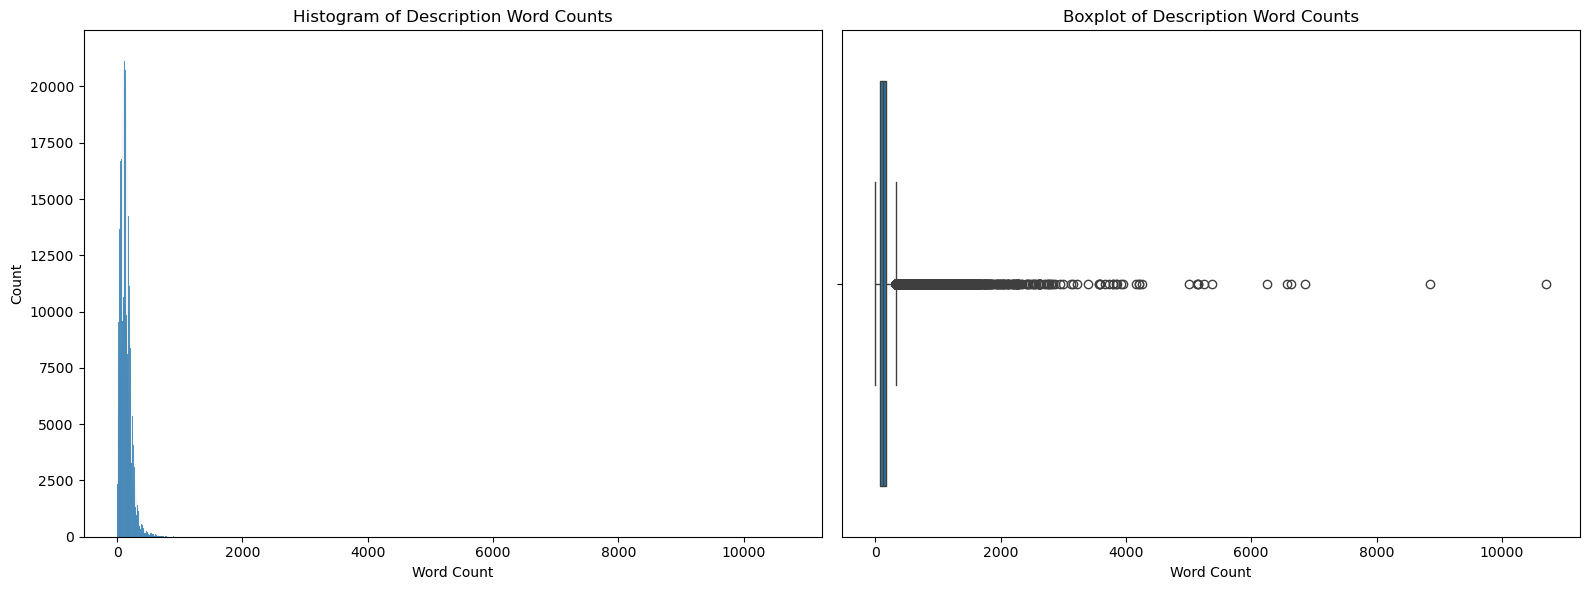

In [28]:
%matplotlib inline

df['description_word_counts'] = df['description_word_counts'].astype('Int64')
print(df['description_word_counts'].describe())

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(x=df['description_word_counts'], ax=ax[0])
ax[0].set_title('Histogram of Description Word Counts')
ax[0].set_xlabel('Word Count')

sns.boxplot(x=df['description_word_counts'], ax=ax[1])
ax[1].set_title('Boxplot of Description Word Counts')
ax[1].set_xlabel('Word Count')

plt.tight_layout()


## Book size (number of pages)

In [76]:
df['num_pages'] = df['num_pages'].astype('Int64')

print(df['num_pages'].describe())

count     1528002.0
mean     264.679327
std      839.191107
min             0.0
25%           150.0
50%           248.0
75%           346.0
max        945077.0
Name: num_pages, dtype: Float64


#### makes sense...

In [78]:
df[df['num_pages'] == df['num_pages'].max()]

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,image_url_large,description_word_counts
18037,NaN,30,[],US,eng,"[{'count': '46530', 'name': 'currently-reading...",B003ODIZL6,true,3.97,NaN,...,2008,https://www.goodreads.com/book/show/18684543-t...,https://images.gr-assets.com/books/1382015770m...,18684543,378,762000,The New Oxford American Dictionary,The New Oxford American Dictionary,https://images.gr-assets.com/books/1382015770l...,150


## Handling the outliers
I use the Inter Quartile Range (IQR) rule to check for outliers, which is what the boxplot also uses, which bounds the data with $\mu \pm 1.5 * IQR$. This is 2.9% of the total data, however many of the 'outliers' still have a reasonable word count, so we don't just want to drop them. Also because we are using a multimodal model, it will be good to train it on instances where the description is small or very large, as they are very much possible instances.

In [31]:
col = 'description_word_counts'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
display(outliers)
print(len(outliers)/len(df))

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,image_url_large,description_word_counts
80,0446537764,1,[],US,NaN,"[{'count': '212', 'name': 'to-read'}, {'count'...",NaN,true,2.86,NaN,...,2008,https://www.goodreads.com/book/show/7075301-i-...,https://images.gr-assets.com/books/1355827385m...,7075301,1,2349629,I'm with Stupid,I'm with Stupid,https://images.gr-assets.com/books/1355827385l...,332
110,8293326247,6,[],US,eng,"[{'count': '171', 'name': 'to-read'}, {'count'...",NaN,false,4.14,NaN,...,2014,https://www.goodreads.com/book/show/22722787-t...,https://s.gr-assets.com/assets/nophoto/book/11...,22722787,18,42251489,The Cost of Doing Business,The Cost of Doing Business,https://s.gr-assets.com/assets/nophoto/book/11...,418
111,NaN,4,[730624],US,en-CA,"[{'count': '93', 'name': 'to-read'}, {'count':...",B00Q5JU7DA,true,3.14,NaN,...,NaN,https://www.goodreads.com/book/show/23815926-t...,https://s.gr-assets.com/assets/nophoto/book/11...,23815926,27,43429205,The Belonging Series (Belonging #1-3),The Belonging Series (Belonging #1-3),https://s.gr-assets.com/assets/nophoto/book/11...,395
155,NaN,4,[627799],US,eng,"[{'count': '247', 'name': 'to-read'}, {'count'...",B00FNB0FA6,true,3.77,B00FNB0FA6,...,2013,https://www.goodreads.com/book/show/18628483-t...,https://images.gr-assets.com/books/1380976538m...,18628483,53,41352626,The Blood and Light Series (Blood and Light #1-6),The Blood and Light Series (Blood and Light #1-6),https://images.gr-assets.com/books/1380976538l...,368
181,NaN,6,[],US,eng,"[{'count': '4', 'name': 'to-read'}, {'count': ...",B013XTFHIY,true,3.77,B013XTFHIY,...,NaN,https://www.goodreads.com/book/show/26106944-a...,https://s.gr-assets.com/assets/nophoto/book/11...,26106944,13,46051672,A Taste of Candy,A Taste of Candy,https://s.gr-assets.com/assets/nophoto/book/11...,396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360482,0679311505,17,[],US,NaN,"[{'count': '99', 'name': 'to-read'}, {'count':...",NaN,false,3.13,NaN,...,2007,https://www.goodreads.com/book/show/831794.Rad...,https://s.gr-assets.com/assets/nophoto/book/11...,831794,93,817444,Radiance,Radiance,https://s.gr-assets.com/assets/nophoto/book/11...,513
2360517,0373773404,26,[199815],US,NaN,"[{'count': '1415', 'name': 'to-read'}, {'count...",NaN,false,4.06,B00348UN8Y,...,2008,https://www.goodreads.com/book/show/3405157-th...,https://s.gr-assets.com/assets/nophoto/book/11...,3405157,100,2682162,These Old Shades,These Old Shades,https://s.gr-assets.com/assets/nophoto/book/11...,373
2360569,0807061476,51,[],US,NaN,"[{'count': '406', 'name': 'to-read'}, {'count'...",NaN,false,4.09,B0053CUN16,...,2009,https://www.goodreads.com/book/show/6093345-th...,https://images.gr-assets.com/books/1320482184m...,6093345,207,6270354,The Lonely Soldier: The Private War of Women S...,The Lonely Soldier: The Private War of Women S...,https://images.gr-assets.com/books/1320482184l...,389
2360591,NaN,1,[766771],US,eng,"[{'count': '161', 'name': 'to-read'}, {'count'...",NaN,true,4.53,NaN,...,2015,https://www.goodreads.com/book/show/25677723-m...,https://images.gr-assets.com/books/1433608029m...,25677723,1,44867712,"My Soul To Wake (Stain, #1)","My Soul To Wake (Stain, #1)",https://images.gr-assets.com/books/1433608029l...,416


0.028513168582440122


## Language code
It is also interesting that the dataset is multilingual, with 214 different language codes, however the distribution is very skewed and a lot of rows are missing a language_code. As can be expected, English is the dominant language, covering 66% of the total rows that have a language code. A multilingual LLM can be used, however depending on the model, it might be necessary to drop some languages from the data. Also, it may be preferred to only train the classifier on English books, as the users of the final system likely do not want recommendations in a language other than English (or Dutch). For now it is more important to handle the missing values, which I will impute with the detected language from the description, or title if the description is NaN.

In [61]:
language_counts = df['language_code'].value_counts()
display(row_counts.describe())
top10= row_counts.sort_values(by='count', ascending=False).head(10)
display(top10)
display(round(top10.head(3)['count'].sum()/row_counts['count'].sum(), 3))
print('\n\nDutch books: \n', df[df['language_code'] == 'nl'].shape[0])


,count
count,263.000000
mean,7886.498099
std,64371.780461
min,1.000000
25%,2.000000
50%,12.000000
75%,533.000000
max,790602.000000


,language_code,count
63,en,790602
68,eng,674618
67,en-US,86369
65,en-GB,55798
217,spa,52745
122,ita,50040
15,ara,38354
84,fre,30988
89,ger,29815
115,ind,23581


0.748



Dutch books: 
 18512


In [59]:
from langdetect import detect, DetectorFactory
from tqdm.notebook import tqdm

# random seed
DetectorFactory.seed = 749

tqdm.pandas()

def detect_language_from_description_or_title(row):
    text = row.get('description', '')
    if pd.isnull(text) or text.strip() == "":
        text = row.get('title', '')
    try:
        return detect(text) if text and text.strip() != "" else None
    except Exception:
        return None

mask = df['language_code'].isnull()

df.loc[mask, 'language_code'] = df.loc[mask].progress_apply(detect_language_from_description_or_title, axis=1)

row_counts = df.groupby('language_code').size().reset_index(name='count')
display(row_counts)


  0%|          | 0/836490 [00:00<?, ?it/s]

,language_code,count
0,--,100
1,abk,7
2,ace,2
3,ach,1
4,ada,1
...,...,...
258,yid,2
259,zap,1
260,zh-cn,7
261,zh-tw,11


In [67]:
display(df.shape)

(2074445, 31)

In [75]:
df.to_parquet("preprocessed_books_2025_03_23.parquet", index=False, compression="snappy")